* Add Data source
* OOP
* Clean code
* Front-end
* Add filter options 
* Add tests

In [ ]:
tfl_polygon = tfl_stations.unary_union.convex_hull
tfl_polygon

In [ ]:
x, y = tfl_polygon.exterior.coords.xy

Imports

In [1]:
from keplergl import KeplerGl
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import httpx
import requests
import folium 
import datetime
import hvplot.pandas

ImportError: cannot import name 'append_docstring' from 'bokeh.util.string' (/Users/tadios/.conda/envs/Coursework/lib/python3.9/site-packages/bokeh/util/string.py)

## Mapping 

In [ ]:
map_ = folium.Map(location=[51.5074,0.1278],tiles = "CartoDB positron")
map_

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot()

Output hidden; open in https://colab.research.google.com to view.

# TFL Station Locations

In [ ]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

tfl_stations = gpd.read_file('stations.kml', driver='KML')
tfl_stations.geometry = gpd.points_from_xy(tfl_stations.geometry.x, tfl_stations.geometry.y)

In [ ]:
tfl_stations_map = KeplerGl(data={'tfl_stations':tfl_stations})
tfl_stations_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'tfl_stations':                            Name  \
0            Acton Town Station   
1        …

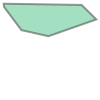

In [ ]:
tfl_polygon = tfl_stations.unary_union.convex_hull
tfl_polygon

In [ ]:
x, y = tfl_polygon.exterior.coords.xy
print(x,y)

array('d', [-0.1947907008345152, -0.4460587669779373, -0.607478839102469, -0.6112192463249099, 0.1138669155835709, 0.25108711606680095, -0.1947907008345152]) array('d', [51.40233694076687, 51.458553104092005, 51.67414971062973, 51.70503045482961, 51.69362460756548, 51.55888907616999, 51.40233694076687])


In [ ]:
mode_meta_query = httpx.get("https://api.tfl.gov.uk/Line/Meta/Modes")

In [ ]:
modes = [mode['modeName'] for mode in mode_meta_query.json() if mode['isScheduledService']]
modes.remove('bus')
modes.remove('coach')

In [ ]:
stops = []
for mode in modes:
    mode_status_query = httpx.get(f'https://api.tfl.gov.uk/line/mode/{mode}/status')
    lines = {line['id']: line['name'] for line in mode_status_query.json() if line['modeName']==mode}
    for line_id, line_name in lines.items():
        lines_info = httpx.get(f'https://api.tfl.gov.uk/line/{line_id}/stoppoints')
        result = []
        for line_info in lines_info.json():  
            try:
                result_ = dict(Name=line_info['commonName'], mode=mode, line=line_name, geometry=Point(line_info['lon'], line_info['lat'])) 
            except:
                result_ = lines_info.json()    
            result.append(result_)
        stops.extend(result) 

In [ ]:
stops

In [ ]:
stations = gpd.GeoDataFrame(stops, crs="EPSG:4326", geometry='geometry')
stations['line'] = stations.groupby('Name')['line'].transform(', '.join)
stations = stations.drop_duplicates()

In [ ]:
tfl_stations = KeplerGl(data=stations)
tfl_stations

In [ ]:
x = 0
stopID = []
stoppingpoint = input('Enter the station: ')
url = f'https://api.tfl.gov.uk/Stoppoint/Search/{stoppingpoint}'  
r =  requests.get(url).json()

while x == 0:  
  if r['total'] == 0:
    print('There are no matches for your input')
    stoppingpoint = input('Please re-enter the station: ')
    url = f'https://api.tfl.gov.uk/Stoppoint/Search/{stoppingpoint}' 
    r =  requests.get(url).json()
  else:
    if r['total'] > 1:
      for dicts in r['matches']:
        stopID.append(dicts['id'])
    x = 1

stopID

In [ ]:
url = 'https://api.tfl.gov.uk/Stoppoint/Search/Kennedy'
r =  requests.get(url).json()
stopID = []

for dicts in r['matches']:
  stopID.append(dicts['id'])

stopID

# Crime API

**Info:**


https://data.police.uk/docs/method/crime-street/

lat=52.629729&lng=-1.131592

**Generic API call:**

https://data.police.uk/api/crimes-street/all-crimes?lat=51.5074&lng=0.1278&date=2021-07


all-crimes - can be changed to filter for specific crime types

date=2021-07 - can be changed to filter for specific dates in the form y1y2y3y4/m1m2

lat=51.5074&lng=0.1278 - can be changed to filter for certain neighbourhoods

{y[0]},{x[0]}:{y[1]},{x[1]}:{y[2]},{x[2]}:{y[3]},{x[3]}:{y[4]},{x[4]}:{y[5]},{x[5]}:{y[6]},{x[6]}


51.696161,-0.504971:51.311227,-0.496171:51.691990,0.287200:51.298133,0.221950

Getting crime categories for a chosen date

https://data.police.uk/docs/method/crime-categories/

In [62]:
categories = 'https://data.police.uk/api/crime-categories'
r = requests.get(categories).json()
r

cat_names = [r[i]['name'] for i in range(len(r))]
cat_url = [r[i]['url'] for i in range(len(r))]

dates = pd.date_range('2011-08','2021-07', 
              freq='MS').strftime("%Y-%m").tolist()
 
print(cat_url, cat_names, dates)

['all-crime', 'anti-social-behaviour', 'bicycle-theft', 'burglary', 'criminal-damage-arson', 'drugs', 'other-theft', 'possession-of-weapons', 'public-order', 'robbery', 'shoplifting', 'theft-from-the-person', 'vehicle-crime', 'violent-crime', 'other-crime'] ['All crime', 'Anti-social behaviour', 'Bicycle theft', 'Burglary', 'Criminal damage and arson', 'Drugs', 'Other theft', 'Possession of weapons', 'Public order', 'Robbery', 'Shoplifting', 'Theft from the person', 'Vehicle crime', 'Violence and sexual offences', 'Other crime'] ['2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2

Allowing a user to choose a date 

In [10]:
from datetime import date
from dateutil.relativedelta import relativedelta

last_month = datetime.now() - relativedelta(months=1)

today = date.today().strftime("%Y-%m")
print("Today's date:", today)
print(last_month)
# print(f'Data is availbale from 2011-08 to {date.today().strftime("%Y-%m")}')

AttributeError: ignored

Allowing a user to choose a  crime category for a specific date

In [63]:
crime_options = {'categories':cat_names}             
crime_options_df = pd.DataFrame.from_dict(crime_options)
print('Here are the following options:')
display(crime_options_df)

cat_choice = input(f'Choose a number from 0 to {len(cat_names)-1} to choose a specific crime category: ')

Here are the following options:


,categories
0,All crime
1,Anti-social behaviour
2,Bicycle theft
3,Burglary
4,Criminal damage and arson
5,Drugs
6,Other theft
7,Possession of weapons
8,Public order
9,Robbery


Choose a number from 0 to 14 to choose a specific crime category: 7


Crime and Date specific API call for London

In [64]:
url = f'https://data.police.uk/api/crimes-street/{cat_url[int(cat_choice)]}?poly=51.705417,-0.559440:51.701934,0.263004:51.301087,0.281818:51.298187,-0.513268&date=2021-07'
r = requests.get(url).json()
print(r)
crime_df = pd.DataFrame(r)
crime_df

[{'category': 'possession-of-weapons', 'location_type': 'Force', 'location': {'latitude': '51.636056', 'street': {'id': 985910, 'name': 'On or near Petrol Station'}, 'longitude': '-0.013542'}, 'context': '', 'outcome_status': {'category': 'Under investigation', 'date': '2021-07'}, 'persistent_id': '74057a6f5a7e419565b3fb8899f66ed19f97415f4c3b3cb63fa979b442cd3bdb', 'id': 93984083, 'location_subtype': '', 'month': '2021-07'}, {'category': 'possession-of-weapons', 'location_type': 'Force', 'location': {'latitude': '51.347860', 'street': {'id': 925880, 'name': 'On or near Roman Way'}, 'longitude': '-0.164118'}, 'context': '', 'outcome_status': {'category': 'Under investigation', 'date': '2021-07'}, 'persistent_id': '09afb899a49da6c846e7369cb305cc5f0255368ecba12d72951338219ba36052', 'id': 93986736, 'location_subtype': '', 'month': '2021-07'}, {'category': 'possession-of-weapons', 'location_type': 'Force', 'location': {'latitude': '51.465916', 'street': {'id': 943992, 'name': 'On or near Orc

,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month
0,possession-of-weapons,Force,"{'latitude': '51.636056', 'street': {'id': 985...",,"{'category': 'Under investigation', 'date': '2...",74057a6f5a7e419565b3fb8899f66ed19f97415f4c3b3c...,93984083,,2021-07
1,possession-of-weapons,Force,"{'latitude': '51.347860', 'street': {'id': 925...",,"{'category': 'Under investigation', 'date': '2...",09afb899a49da6c846e7369cb305cc5f0255368ecba12d...,93986736,,2021-07
2,possession-of-weapons,Force,"{'latitude': '51.465916', 'street': {'id': 943...",,"{'category': 'Under investigation', 'date': '2...",54d8be8a8d3cc9d5727ac3cee8fa48e88d5aaeb5ea6958...,93991757,,2021-07
3,possession-of-weapons,Force,"{'latitude': '51.469717', 'street': {'id': 945...",,"{'category': 'Under investigation', 'date': '2...",35d3fc2090fa39096aa9e0f7dba5af3aa443ca9a3eeed1...,93992172,,2021-07
4,possession-of-weapons,Force,"{'latitude': '51.554588', 'street': {'id': 968...",,"{'category': 'Awaiting court outcome', 'date':...",169f1a06d996a90a8a51ee1c3eb7cd9a7300f42bc4fc60...,94002896,,2021-07
...,...,...,...,...,...,...,...,...,...
496,possession-of-weapons,BTP,"{'latitude': '51.505984', 'street': {'id': 149...",,"{'category': 'Under investigation', 'date': '2...",,94888006,STATION,2021-07
497,possession-of-weapons,BTP,"{'latitude': '51.518713', 'street': {'id': 148...",,"{'category': 'Under investigation', 'date': '2...",,94889285,STATION,2021-07
498,possession-of-weapons,BTP,"{'latitude': '51.518713', 'street': {'id': 148...",,"{'category': 'Under investigation', 'date': '2...",,94889286,STATION,2021-07
499,possession-of-weapons,BTP,"{'latitude': '51.528000', 'street': {'id': 148...",,"{'category': 'Under investigation', 'date': '2...",,94889045,STATION,2021-07


Creating a geopandas Dataframe by unpacking the dictionary column holding latitudes and longitudes from a pandas Dataframe

In [65]:
locations = crime_df.location.apply(pd.Series)
crime_gdf = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(locations.longitude, locations.latitude))
display(locations)
crime_gdf.head()

,latitude,street,longitude
0,51.636056,"{'id': 985910, 'name': 'On or near Petrol Stat...",-0.013542
1,51.347860,"{'id': 925880, 'name': 'On or near Roman Way'}",-0.164118
2,51.465916,"{'id': 943992, 'name': 'On or near Orchid Gard...",-0.376316
3,51.469717,"{'id': 945476, 'name': 'On or near Rosebury Ro...",-0.189452
4,51.554588,"{'id': 968111, 'name': 'On or near Bellina Mews'}",-0.140544
...,...,...,...
496,51.505984,"{'id': 1490345, 'name': 'London Bridge (statio...",-0.084053
497,51.518713,"{'id': 1489886, 'name': 'Paddington (station)'}",-0.176382
498,51.518713,"{'id': 1489886, 'name': 'Paddington (station)'}",-0.176382
499,51.528000,"{'id': 1486616, 'name': 'West Ham (dlr)'}",0.005042


,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,geometry
0,possession-of-weapons,Force,"{'latitude': '51.636056', 'street': {'id': 985...",,"{'category': 'Under investigation', 'date': '2...",74057a6f5a7e419565b3fb8899f66ed19f97415f4c3b3c...,93984083,,2021-07,POINT (-0.01354 51.63606)
1,possession-of-weapons,Force,"{'latitude': '51.347860', 'street': {'id': 925...",,"{'category': 'Under investigation', 'date': '2...",09afb899a49da6c846e7369cb305cc5f0255368ecba12d...,93986736,,2021-07,POINT (-0.16412 51.34786)
2,possession-of-weapons,Force,"{'latitude': '51.465916', 'street': {'id': 943...",,"{'category': 'Under investigation', 'date': '2...",54d8be8a8d3cc9d5727ac3cee8fa48e88d5aaeb5ea6958...,93991757,,2021-07,POINT (-0.37632 51.46592)
3,possession-of-weapons,Force,"{'latitude': '51.469717', 'street': {'id': 945...",,"{'category': 'Under investigation', 'date': '2...",35d3fc2090fa39096aa9e0f7dba5af3aa443ca9a3eeed1...,93992172,,2021-07,POINT (-0.18945 51.46972)
4,possession-of-weapons,Force,"{'latitude': '51.554588', 'street': {'id': 968...",,"{'category': 'Awaiting court outcome', 'date':...",169f1a06d996a90a8a51ee1c3eb7cd9a7300f42bc4fc60...,94002896,,2021-07,POINT (-0.14054 51.55459)


Plotting map of points using kepler

In [ ]:
crime_map = KeplerGl(height=400, data={'crime_gdf':crime_gdf})
crime_map

In [66]:
crimemap = crime_gdf.hvplot(geo=True,
                            title='Crime in London',
                            marker='x',
                            color='red',
                            size=20,
                            tiles='CartoLight', 
                            hover_cols=["category"])
crimemap

AttributeError: 'GeoDataFrame' object has no attribute 'hvplot'

Plotting table showing the number of crimes committed for each type

In [45]:
counts = crime_df['category'].value_counts()
display(counts)

possession-of-weapons    501
Name: category, dtype: int64

Plotting histograms on each crimes occurence in a fixed year

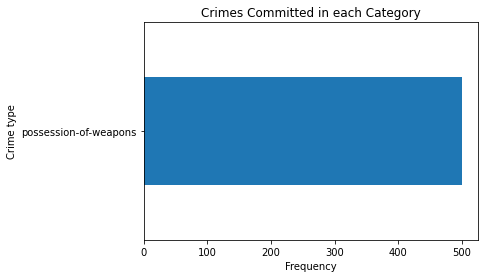

In [46]:
counts.plot(kind='barh')

plt.title('Crimes Committed in each Category')
plt.xlabel('Frequency')
plt.ylabel('Crime type')
plt.show()

# Weather API

api key: b19414406c70effb25f6b8de609f3945, open weather api

# Air Quality API

In [ ]:
latest_london_air_quality = httpx.get("https://api.erg.ic.ac.uk/AirQuality/Daily/MonitoringIndex/Latest/GroupName=London/Json")

ReadTimeout: The read operation timed out

In [ ]:
local_authority_air_quality = latest_london_air_quality.json()['DailyAirQualityIndex']['LocalAuthority']

In [ ]:
def parse_data_from_sites(result: dict, site: dict, species, local_authority: dict):
    site_name = f"{site['@SiteCode']}{species['@SpeciesCode']}"
    result[site_name] = dict(
        SiteName=site['@SiteName'],
        LocalAuthorityName=local_authority['@LocalAuthorityName'],
        Latitude=site['@Latitude'],
        Longitude=site['@Longitude'],
        Species=str(dict(SpeciesCode=species['@SpeciesCode'],
        SpeciesDescription=species['@SpeciesDescription'],
        AirQualityIndex=species['@AirQualityIndex'],
        AirQualityBand=species['@AirQualityBand']))
    )
    return result

In [ ]:
def parse_data_from_site(result, site, local_authority):
    species = site['Species']
    if isinstance(species, list):
        for single_species in species:
            result = parse_data_from_sites(result, site, single_species, local_authority)
    elif isinstance(species, dict):
        result = parse_data_from_sites(result, site, species, local_authority)
    return result

In [ ]:
result_dict = dict()

for local_authority_data in local_authority_air_quality:
    if 'Site' in local_authority_data:
        sites_data = local_authority_data['Site']
        if isinstance(sites_data, list):
            for site_data in sites_data:
                parse_data_from_site(result_dict, site_data, local_authority_data)
        elif isinstance(sites_data, dict):
                parse_data_from_site(result_dict, sites_data, local_authority_data)

NameError: name 'local_authority_air_quality' is not defined

In [ ]:
air_quality_df = pd.DataFrame.from_dict(result_dict).T

In [ ]:
air_quality_df['Species'] = air_quality_df.groupby('SiteName')['Species'].transform(' '.join)

KeyError: 'SiteName'

In [ ]:
air_quality_df

NameError: name 'air_quality_df' is not defined

In [ ]:
air_quality_df = air_quality_df.groupby('SiteName').first()

KeyError: 'SiteName'

In [ ]:
air_quality = gpd.GeoDataFrame(air_quality_df, crs="EPSG:4326", 
                              geometry=gpd.points_from_xy(air_quality_df['Longitude'], air_quality_df['Latitude']))

NameError: name 'air_quality_df' is not defined

In [ ]:
air_quality.tail()['Species'][0]

"{'SpeciesCode': 'NO2', 'SpeciesDescription': 'Nitrogen Dioxide', 'AirQualityIndex': '1', 'AirQualityBand': 'Low'} {'SpeciesCode': 'PM25', 'SpeciesDescription': 'PM2.5 Particulate', 'AirQualityIndex': '1', 'AirQualityBand': 'Low'}"

In [ ]:
air_quality_map = KeplerGl(data={'air_quality': air_quality})
air_quality_map

NameError: name 'air_quality' is not defined

# Map